# Neural Network - Similiarity Function

This notebook details the process of choosing the similarity function that determines the images that are similar to a given image.
The implementation of the network is based on the Siamese network implementation. This class of networks is known to be more robust to class imbalance, so it fits the data on which we train.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the data
base_path = 'active_learning_labels/'
full_data_paths = pd.read_csv(base_path + 'round_0.csv')

current_round = 1

if current_round > 0:
    for i in range(1, current_round):
        path = base_path + 'round_' + str(i) + '.csv'
        data = pd.read_csv(path)
        full_data_paths = pd.concat([full_data_paths, data], ignore_index=True)

data_paths = full_data_paths[['image1_path', 'image2_path', 'similarity']]

print(data_paths.head())

                                         image1_path  \
0  (datasets/house_styles/all_images/001_d2c7428a...   
1  (datasets/house_styles/all_images/453_d7b5d246...   
2  (datasets/house_styles/all_images/116_32f01ef6...   
3  (datasets/house_styles/all_images/301_b73b9663...   
4  (datasets/house_styles/all_images/042_06b56791...   

                                         image2_path  similarity  
0  (datasets/house_styles/all_images/366_08eff319...         3.0  
1  (datasets/house_styles/all_images/122_e44a0cb3...         0.0  
2  (datasets/house_styles/all_images/174_55a7b3f9...         0.0  
3  (datasets/house_styles/all_images/116_32f01ef6...         0.0  
4  (datasets/house_styles/all_images/069_d3bedc1f...         1.0  


In [3]:
# split the data into training and testing
train_data = data_paths.sample(frac=0.8, random_state=42)
eval_data = data_paths.drop(train_data.index)

print("Train: ", train_data.shape, "Eval: ", eval_data.shape)

Train:  (566, 3) Eval:  (142, 3)


### Load Computer Vision Model

In [4]:
# Load the pretrained CLIP model and processor from Hugging Face
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Set up the image transformation pipeline
clip_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Define the dataset class
augmentations = transforms.Compose([
    transforms.RandomApply([transforms.RandomResizedCrop(224)], p=0.3),  # 20% chance of random resized crop
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),  # 20% chance of horizontal flip
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.3),  # 20% chance of color jitter
    transforms.ToTensor(),  # Always apply ToTensor
])


In [5]:
class ImageSimilarityDataset(Dataset):
    def __init__(self, dataframe, transform=clip_transform, augmentations=None):
        self.data = dataframe
        self.transform = transform
        self.augmentations = augmentations
        self.master_path = ''

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load images from the paths
        image1_path = self.master_path + self.data.iloc[idx, 0].strip("()")
        image2_path = self.master_path + self.data.iloc[idx, 1].strip("()")
        
        # Load images
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")

        # Apply augmentations if provided
        if self.augmentations:
            image1 = self.augmentations(image1)
            image2 = self.augmentations(image2)

        # # CLIP:
        # images_features = []
        # for img in [image1, image2]:
        #     image_tensor = self.transform(img).unsqueeze(0)
        #     inputs = processor(images=image_tensor, return_tensors="pt")
        #     with torch.no_grad():
        #         image_features = model.get_image_features(**inputs)
        #         #images_features.append(image_features.numpy().flatten())
        #     images_features.append(image_features.squeeze())  # Ensure it's a 512-dimensional tensor

        
        # Apply CLIP transforms if provided (transforms should convert to tensor)
        if self.transform:
            image1 = self.transform(image1)  # Apply transforms including ToTensor
            image2 = self.transform(image2)

        # Get image features using CLIP
        images_features = []
        for img in [image1, image2]:
            image_tensor = img.unsqueeze(0)  # Add batch dimension for processing
            inputs = processor(images=image_tensor, return_tensors="pt")
            with torch.no_grad():
                image_features = model.get_image_features(**inputs)
            images_features.append(image_features.squeeze())  # Ensure it's a 512-dimensional tensor

        # Get similarity score and label (1 for similar, 0 for dissimilar)
        similarity = self.data.iloc[idx, 2]
        label = 0 if similarity < 3 else 1
        
        return image1_path, image2_path, images_features[0], images_features[1], torch.tensor(label, dtype=torch.float32)


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device('cpu')

print(device)

cuda


In [7]:
# Create datasets
train_dataset = ImageSimilarityDataset(train_data, transform=clip_transform, augmentations=None)
eval_dataset = ImageSimilarityDataset(eval_data, transform=clip_transform, augmentations=None)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        # self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)  # Keep larger dimension here
        self.relu = nn.ReLU()

    def forward_one(self, x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


In [42]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         # Using fully connected layers to process 512-dimensional CLIP features
#         self.fc1 = nn.Sequential(
#             nn.Linear(512, 256),  # First layer to reduce dimensions
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(256, 128),  # Second layer
#             nn.ReLU(inplace=True),
#             nn.Linear(128, 2)     # Output layer with 2 units (for similarity comparison)
#         )

#     def forward_once(self, x):
#         # Forward pass through fully connected layers
#         return self.fc1(x)

#     def forward(self, input1, input2):
#         # Forward pass for both inputs
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2


In [8]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         # Use fully connected layers for processing 512-dimensional CLIP features
#         self.fc1 = nn.Sequential(
#             nn.Linear(512, 256),  # Assuming CLIP outputs 512-dimensional features
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(256, 128),
#             nn.ReLU(inplace=True),
#             nn.Linear(128, 2)
#         )

#     def forward_once(self, x):
#         # Forward pass through fully connected layers
#         x = self.fc1(x)
#         return x

#     def forward(self, input1, input2):
#         # Forward pass of input 1
#         output1 = self.forward_once(input1)
#         # Forward pass of input 2
#         output2 = self.forward_once(input2)
#         return output1, output2


In [9]:
# class SiameseNetwork(nn.Module):
    
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         # Setting up the Sequential of CNN Layers
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=1),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),
            
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),

#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),
#         )
        
#         # Adaptive pooling layer to ensure the output size is consistent
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # Adjust pooling size to handle dynamic input
        
#         # Defining the fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(256 * 6 * 6, 1024),  # Input size adjusted for adaptive pooling
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
            
#             nn.Linear(1024, 128),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(128, 2)
#         )
        
#     def forward_once(self, x):
#         # Forward pass 
#         x = self.cnn1(x)
#         x = self.adaptive_pool(x)  # Adaptive pooling to standardize the feature map size
#         x = x.view(x.size(0), -1)  # Flatten the feature map
#         x = self.fc1(x)
#         return x

#     def forward(self, input1, input2):
#         # Forward pass of input 1
#         output1 = self.forward_once(input1)
#         # Forward pass of input 2
#         output2 = self.forward_once(input2)
#         return output1, output2

# # class SiameseNetwork(nn.Module):
    
# #     def __init__(self):
# #         super(SiameseNetwork, self).__init__()
# #         # Setting up the Sequential of CNN Layers
# #         self.cnn1 = nn.Sequential(
# #             nn.Conv2d(3, 96, kernel_size=11, stride=1),  # Adjusted for RGB input
# #             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(3, stride=2),
            
# #             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
# #             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(3, stride=2),
# #             nn.Dropout2d(p=0.3),

# #             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
# #             nn.ReLU(inplace=True),
            
# #             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(3, stride=2),
# #             nn.Dropout2d(p=0.3),
# #         )
        
# #         # Adaptive pooling layer to ensure the output size is consistent
# #         self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # Adjust pooling size to handle dynamic input
        
# #         # Defining the fully connected layers
# #         self.fc1 = nn.Sequential(
# #             nn.Linear(256 * 6 * 6, 1024),  # Input size adjusted for adaptive pooling
# #             nn.ReLU(inplace=True),
# #             nn.Dropout(p=0.5),
            
# #             nn.Linear(1024, 128),
# #             nn.ReLU(inplace=True),
            
# #             nn.Linear(128, 2)
# #         )
        
# #     def forward_once(self, x):
# #         # Forward pass 
# #         x = self.cnn1(x)
# #         x = self.adaptive_pool(x)  # Adaptive pooling to standardize the feature map size
# #         x = x.view(x.size(0), -1)  # Flatten the feature map
#     #     x = self.fc1(x)
#     #     return x

#     # def forward(self, input1, input2):
#     #     # Forward pass of input 1
#     #     output1 = self.forward_once(input1)
#     #     # Forward pass of input 2
#     #     output2 = self.forward_once(input2)
#     #     return output1, output2


In [43]:
# class SmallSiameseNetwork(nn.Module):
    
#     def __init__(self):
#         super(SmallSiameseNetwork, self).__init__()
#         # Setting up a smaller CNN
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=1),  # Fewer filters, smaller kernel size
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, stride=2),  # Max pooling with smaller stride to reduce spatial dimensions
#             nn.Dropout2d(p=0.2),  # Reduced dropout rate
            
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  # Fewer filters
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, stride=2),  # Smaller max-pooling
#             nn.Dropout2d(p=0.2),

#             # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Fewer filters
#             # nn.ReLU(inplace=True),
#             # nn.MaxPool2d(2, stride=2),
#             # nn.Dropout2d(p=0.2),
#         )
        
#         # Adaptive pooling layer to standardize output size (reduce to 3x3)
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))  # Smaller output size (3x3)
        
#         # Defining smaller fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(64 * 3 * 3, 128),  # Reduced size based on new feature map size
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.4),  # Keep some dropout for regularization
            
#             nn.Linear(128, 64),  # Smaller fully connected layer
#             nn.ReLU(inplace=True),
            
#             nn.Linear(64, 2)  # Output layer remains the same
#         )
        
#     def forward_once(self, x):
#         # Forward pass 
#         x = self.cnn1(x)
#         x = self.adaptive_pool(x)  # Adaptive pooling to standardize the feature map size
#         x = x.view(x.size(0), -1)  # Flatten the feature map
#         x = self.fc1(x)
#         return x

#     def forward(self, input1, input2):
#         # Forward pass of input 1
#         output1 = self.forward_once(input1)
#         # Forward pass of input 2
#         output2 = self.forward_once(input2)
#         return output1, output2


In [9]:
# define the loss function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        ### Binary:
        # euclidian distance
        # diff = x0 - x1
        # dist_sq = torch.sum(torch.pow(diff, 2), 1)
        # if torch.any(dist_sq < 0):
        #     print('the value of dist_sq is negative: ' + dist_sq)
        # # dist = torch.sqrt(torch.abs(dist_sq))
        # dist = torch.sqrt(dist_sq + 1e-6)
        # mdist = self.margin - dist
        # dist = torch.clamp(mdist, min=0.0)
        # loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        # loss = torch.sum(loss) / 2.0 / x0.size()[0]

        label = y #binary?
        euclidean_distance = nn.functional.pairwise_distance(x0, x1)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + # similar
                                (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # dissimilar
        return loss_contrastive
        
        

In [11]:
def train_siamese_network(model, train_loader, eval_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    max_acc = 0
    min_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        
        for i, (img1_path, img2_path, img1, img2, labels) in tqdm(enumerate(train_loader)):
            # Move tensors to the appropriate device
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Accuracy
            dist = F.pairwise_distance(output1, output2)
            predicted = (dist < 1.0).float()
            correct += (predicted == labels).sum().item()

            # Print statistics
            # if (i + 1) % 10 == 0:  # Print every 5 batches
            #     print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}")
            #     running_loss = 0.0

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {correct / len(train_loader.dataset):.2f}")

        if running_loss < min_loss:
            min_loss = running_loss
            best_model = model.state_dict()
            print("Best model updated")

        # Evaluate the model
        # if (epoch + 1) % 5 == 0:
        #     model.eval()
        #     correct = 0
        #     with torch.no_grad():
        #         for img1_path, img2_path, img1, img2, labels in eval_loader:
        #             img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        #             output1, output2 = model(img1, img2)
        #             dist = F.pairwise_distance(output1, output2)
        #             predicted = (dist < 1.0).float()
        #             correct += (predicted == labels).sum().item()
        #     eval_acc = correct / len(eval_loader.dataset)
        #     print(f"Evaluation Accuracy: {eval_acc:.2f}")

        #     # Save the model with the best evaluation accuracy
        #     if eval_acc >= max_acc:
        #         max_acc = eval_acc
        #         best_model = model.state_dict()
        #         print("Best model updated")

    return best_model

In [12]:
siamese_net = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.01)
num_epochs = 100

In [13]:
trained_model = train_siamese_network(siamese_net, train_loader, eval_loader, criterion, optimizer, num_epochs)

0it [00:00, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
71it [01:29,  1.27s/it]


Epoch [1/100], Loss: 0.2969, Train Accuracy: 0.59
Best model updated


71it [01:30,  1.28s/it]


Epoch [2/100], Loss: 0.2281, Train Accuracy: 0.62
Best model updated


71it [01:29,  1.26s/it]


Epoch [3/100], Loss: 0.2199, Train Accuracy: 0.64
Best model updated


71it [01:27,  1.23s/it]


Epoch [4/100], Loss: 0.1662, Train Accuracy: 0.58
Best model updated


71it [01:27,  1.24s/it]


Epoch [5/100], Loss: 0.1605, Train Accuracy: 0.59
Best model updated


71it [01:27,  1.24s/it]


Epoch [6/100], Loss: 0.2039, Train Accuracy: 0.63


71it [01:27,  1.23s/it]


Epoch [7/100], Loss: 0.4349, Train Accuracy: 0.70


71it [01:27,  1.24s/it]


Epoch [8/100], Loss: 1.8579, Train Accuracy: 0.86


71it [01:27,  1.23s/it]


Epoch [9/100], Loss: 0.8381, Train Accuracy: 0.82


71it [01:25,  1.20s/it]


Epoch [10/100], Loss: 0.2289, Train Accuracy: 0.70


71it [01:25,  1.20s/it]


Epoch [11/100], Loss: 0.1513, Train Accuracy: 0.61
Best model updated


71it [01:26,  1.22s/it]


Epoch [12/100], Loss: 0.1114, Train Accuracy: 0.61
Best model updated


71it [01:26,  1.22s/it]


Epoch [13/100], Loss: 0.1106, Train Accuracy: 0.69
Best model updated


71it [01:25,  1.20s/it]


Epoch [14/100], Loss: 0.1076, Train Accuracy: 0.68
Best model updated


71it [01:28,  1.25s/it]


Epoch [15/100], Loss: 0.1112, Train Accuracy: 0.61


71it [01:25,  1.21s/it]


Epoch [16/100], Loss: 0.0853, Train Accuracy: 0.66
Best model updated


71it [01:26,  1.21s/it]


Epoch [17/100], Loss: 0.1005, Train Accuracy: 0.64


71it [01:26,  1.22s/it]


Epoch [18/100], Loss: 0.0923, Train Accuracy: 0.67


71it [01:27,  1.23s/it]


Epoch [19/100], Loss: 0.0793, Train Accuracy: 0.68
Best model updated


71it [01:25,  1.20s/it]


Epoch [20/100], Loss: 0.0645, Train Accuracy: 0.71
Best model updated


71it [01:24,  1.19s/it]


Epoch [21/100], Loss: 0.0801, Train Accuracy: 0.69


71it [01:27,  1.23s/it]


Epoch [22/100], Loss: 0.0871, Train Accuracy: 0.69


71it [01:24,  1.20s/it]


Epoch [23/100], Loss: 0.0628, Train Accuracy: 0.72
Best model updated


71it [01:29,  1.27s/it]


Epoch [24/100], Loss: 0.0569, Train Accuracy: 0.75
Best model updated


71it [01:27,  1.23s/it]


Epoch [25/100], Loss: 0.0523, Train Accuracy: 0.74
Best model updated


71it [01:27,  1.24s/it]


Epoch [26/100], Loss: 0.0553, Train Accuracy: 0.74


71it [01:27,  1.23s/it]


Epoch [27/100], Loss: 0.0675, Train Accuracy: 0.75


71it [01:24,  1.19s/it]


Epoch [28/100], Loss: 0.0464, Train Accuracy: 0.73
Best model updated


71it [01:26,  1.22s/it]


Epoch [29/100], Loss: 0.0424, Train Accuracy: 0.78
Best model updated


71it [01:26,  1.22s/it]


Epoch [30/100], Loss: 0.0434, Train Accuracy: 0.80


71it [01:28,  1.24s/it]


Epoch [31/100], Loss: 0.0447, Train Accuracy: 0.77


71it [01:27,  1.23s/it]


Epoch [32/100], Loss: 0.0569, Train Accuracy: 0.81


71it [01:26,  1.22s/it]


Epoch [33/100], Loss: 0.1320, Train Accuracy: 0.79


71it [01:26,  1.22s/it]


Epoch [34/100], Loss: 0.1000, Train Accuracy: 0.77


71it [01:27,  1.23s/it]


Epoch [35/100], Loss: 0.0614, Train Accuracy: 0.73


71it [01:28,  1.25s/it]


Epoch [36/100], Loss: 0.0581, Train Accuracy: 0.75


71it [01:27,  1.24s/it]


Epoch [37/100], Loss: 0.0465, Train Accuracy: 0.77


71it [01:29,  1.26s/it]


Epoch [38/100], Loss: 0.0540, Train Accuracy: 0.78


71it [01:27,  1.23s/it]


Epoch [39/100], Loss: 0.0538, Train Accuracy: 0.78


71it [01:27,  1.24s/it]


Epoch [40/100], Loss: 0.0450, Train Accuracy: 0.83


71it [01:24,  1.19s/it]


Epoch [41/100], Loss: 0.0972, Train Accuracy: 0.81


71it [01:28,  1.24s/it]


Epoch [42/100], Loss: 3.7945, Train Accuracy: 0.90


71it [01:25,  1.21s/it]


Epoch [43/100], Loss: 28.9140, Train Accuracy: 0.91


71it [01:27,  1.23s/it]


Epoch [44/100], Loss: 4.0878, Train Accuracy: 0.91


71it [01:25,  1.20s/it]


Epoch [45/100], Loss: 0.2258, Train Accuracy: 0.83


71it [01:27,  1.24s/it]


Epoch [46/100], Loss: 0.0931, Train Accuracy: 0.78


71it [01:27,  1.24s/it]


Epoch [47/100], Loss: 0.0733, Train Accuracy: 0.73


71it [01:27,  1.23s/it]


Epoch [48/100], Loss: 0.0625, Train Accuracy: 0.74


71it [01:26,  1.22s/it]


Epoch [49/100], Loss: 0.0534, Train Accuracy: 0.77


71it [01:26,  1.21s/it]


Epoch [50/100], Loss: 0.0491, Train Accuracy: 0.75


71it [01:27,  1.24s/it]


Epoch [51/100], Loss: 0.0456, Train Accuracy: 0.76


71it [01:27,  1.23s/it]


Epoch [52/100], Loss: 0.0452, Train Accuracy: 0.78


71it [01:29,  1.26s/it]


Epoch [53/100], Loss: 0.0411, Train Accuracy: 0.80
Best model updated


71it [01:26,  1.22s/it]


Epoch [54/100], Loss: 0.0396, Train Accuracy: 0.80
Best model updated


71it [01:28,  1.24s/it]


Epoch [55/100], Loss: 0.0378, Train Accuracy: 0.79
Best model updated


71it [01:27,  1.24s/it]


Epoch [56/100], Loss: 0.0379, Train Accuracy: 0.81


71it [01:28,  1.25s/it]


Epoch [57/100], Loss: 0.0342, Train Accuracy: 0.80
Best model updated


71it [01:27,  1.23s/it]


Epoch [58/100], Loss: 0.0311, Train Accuracy: 0.80
Best model updated


71it [01:27,  1.23s/it]


Epoch [59/100], Loss: 0.0314, Train Accuracy: 0.83


71it [01:24,  1.19s/it]


Epoch [60/100], Loss: 0.0307, Train Accuracy: 0.84
Best model updated


71it [01:27,  1.23s/it]


Epoch [61/100], Loss: 0.0309, Train Accuracy: 0.81


71it [01:26,  1.22s/it]


Epoch [62/100], Loss: 0.0269, Train Accuracy: 0.84
Best model updated


71it [01:27,  1.23s/it]


Epoch [63/100], Loss: 0.0272, Train Accuracy: 0.84


71it [01:27,  1.23s/it]


Epoch [64/100], Loss: 0.0267, Train Accuracy: 0.83
Best model updated


71it [01:28,  1.24s/it]


Epoch [65/100], Loss: 0.0261, Train Accuracy: 0.85
Best model updated


71it [01:27,  1.24s/it]


Epoch [66/100], Loss: 0.0328, Train Accuracy: 0.87


71it [01:28,  1.24s/it]


Epoch [67/100], Loss: 0.0250, Train Accuracy: 0.86
Best model updated


71it [01:28,  1.24s/it]


Epoch [68/100], Loss: 0.0281, Train Accuracy: 0.85


71it [01:28,  1.25s/it]


Epoch [69/100], Loss: 0.0252, Train Accuracy: 0.85


71it [01:30,  1.27s/it]


Epoch [70/100], Loss: 0.0272, Train Accuracy: 0.86


71it [01:28,  1.25s/it]


Epoch [71/100], Loss: 0.0236, Train Accuracy: 0.86
Best model updated


71it [01:28,  1.25s/it]


Epoch [72/100], Loss: 0.0264, Train Accuracy: 0.88


71it [01:29,  1.26s/it]


Epoch [73/100], Loss: 0.0231, Train Accuracy: 0.87
Best model updated


71it [01:28,  1.25s/it]


Epoch [74/100], Loss: 0.0277, Train Accuracy: 0.90


71it [01:28,  1.25s/it]


Epoch [75/100], Loss: 0.0231, Train Accuracy: 0.88


71it [01:28,  1.24s/it]


Epoch [76/100], Loss: 0.0274, Train Accuracy: 0.90


71it [01:30,  1.27s/it]


Epoch [77/100], Loss: 0.0413, Train Accuracy: 0.90


71it [01:30,  1.27s/it]


Epoch [78/100], Loss: 0.0402, Train Accuracy: 0.89


71it [01:28,  1.25s/it]


Epoch [79/100], Loss: 0.0480, Train Accuracy: 0.89


71it [01:27,  1.23s/it]


Epoch [80/100], Loss: 0.0333, Train Accuracy: 0.87


71it [01:28,  1.25s/it]


Epoch [81/100], Loss: 0.0391, Train Accuracy: 0.87


71it [01:29,  1.26s/it]


Epoch [82/100], Loss: 0.0487, Train Accuracy: 0.87


71it [01:28,  1.24s/it]


Epoch [83/100], Loss: 0.0424, Train Accuracy: 0.88


71it [01:26,  1.22s/it]


Epoch [84/100], Loss: 0.0595, Train Accuracy: 0.86


71it [01:27,  1.24s/it]


Epoch [85/100], Loss: 0.0377, Train Accuracy: 0.86


71it [01:28,  1.25s/it]


Epoch [86/100], Loss: 0.0369, Train Accuracy: 0.87


71it [01:27,  1.24s/it]


Epoch [87/100], Loss: 0.0266, Train Accuracy: 0.86


71it [01:28,  1.24s/it]


Epoch [88/100], Loss: 0.0243, Train Accuracy: 0.86


71it [01:27,  1.24s/it]


Epoch [89/100], Loss: 0.1481, Train Accuracy: 0.90


71it [01:28,  1.25s/it]


Epoch [90/100], Loss: 0.0651, Train Accuracy: 0.88


71it [01:30,  1.27s/it]


Epoch [91/100], Loss: 0.0259, Train Accuracy: 0.87


71it [01:29,  1.26s/it]


Epoch [92/100], Loss: 0.0444, Train Accuracy: 0.88


71it [01:29,  1.27s/it]


Epoch [93/100], Loss: 0.0317, Train Accuracy: 0.89


71it [01:27,  1.23s/it]


Epoch [94/100], Loss: 0.0269, Train Accuracy: 0.88


71it [01:28,  1.24s/it]


Epoch [95/100], Loss: 0.0294, Train Accuracy: 0.89


71it [01:28,  1.25s/it]


Epoch [96/100], Loss: 0.0241, Train Accuracy: 0.89


71it [01:28,  1.24s/it]


Epoch [97/100], Loss: 0.0344, Train Accuracy: 0.87


71it [01:30,  1.28s/it]


Epoch [98/100], Loss: 0.0646, Train Accuracy: 0.88


71it [01:28,  1.25s/it]


Epoch [99/100], Loss: 0.0922, Train Accuracy: 0.86


71it [01:28,  1.25s/it]

Epoch [100/100], Loss: 0.0346, Train Accuracy: 0.81


In [14]:
# Save the trained model
torch.save(siamese_net.state_dict(), 'siamese_net_4.pth')

In [16]:
# Load the trained model
siamese_net.load_state_dict(torch.load('siamese_net_4.pth'))
trained_model = siamese_net

/tmp/ipykernel_182634/3788960927.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese_net.load_state_dict(torch.load('siamese_net_4.pth'))


Evaluation Accuracy: 0.6972
Test F1 Score: 0.0444


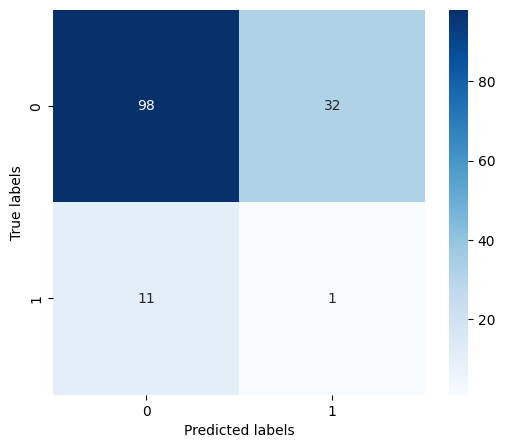

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

def test_siamese_network(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (img1_path, img2_path, img1, img2, labels) in enumerate(test_loader):
            # Move tensors to the appropriate device
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            output1, output2 = model(img1, img2)

            # Calculate the euclidean distance between the outputs
            dist = F.pairwise_distance(output1, output2)

            # Get predictions
            predicted = (dist < 1.0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels)
            all_predictions.extend(predicted)

            # print(f"Dist: {dist}, Predicted: {predicted}, Actual: {labels}")

            # if i == 10:
            #     break

    # accuracy:
    accuracy = correct / total
    print(f"Evaluation Accuracy: {accuracy:.4f}")

    # move to cpu:
    all_labels = [label.cpu().numpy() for label in all_labels]
    all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]

    # f1 score:
    f1 = f1_score(all_labels, all_predictions)
    print(f"Test F1 Score: {f1:.4f}")

    # confusion matrix:
    matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

test_siamese_network(trained_model, eval_loader)

Evaluation Accuracy: 0.8587
Test F1 Score: 0.5455


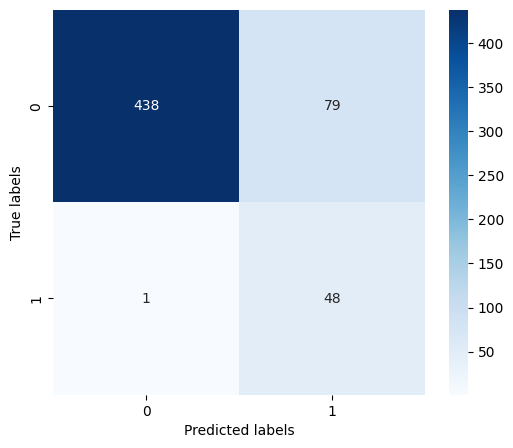

In [18]:
test_siamese_network(trained_model, train_loader)

In [ ]:
# random_test = eval_data.sample(1)
# img1, img2, label = random_test.iloc[0]
# img1 = img1.strip("()")
# img2 = img2.strip("()")

# # Load images
# image1 = Image.open(img1).convert("RGB")
# image2 = Image.open(img2).convert("RGB")

# # Print Images
# display(image1)
# display(image2)

# # Apply transformations
# image1 = transform(image1).unsqueeze(0)
# image2 = transform(image2).unsqueeze(0)

# # Forward pass
# output1, output2 = trained_model(image1, image2)

# # Calculate the euclidean distance between the outputs
# # diff = output1 - output2
# # dist_sq = torch.sum(torch.pow(diff, 2), 1)
# # dist = torch.sqrt(dist_sq)
# dist = F.pairwise_distance(output1, output2)
# print(f"Distance: {dist.item()}")

# # Get predictions
# predicted = (dist < 1.0).float()
# true_label = 0 if label < 2 else 1

# print(f"Predicted: {predicted.item()}, Actual: {true_label}")

In [ ]:
# pca of the output:
from sklearn.decomposition import PCA

# Get the output of the model
outputs = []
labels = []

with torch.no_grad():
    for img1, img2, label in eval_loader:
        output1, output2 = trained_model(img1, img2)
        outputs.append(output1)
        labels.append(label)

outputs = torch.cat(outputs, dim=0)
labels = torch.cat(labels, dim=0)

# Perform PCA
pca = PCA(n_components=2)
pca_outputs = pca.fit_transform(outputs)

# Plot the PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_outputs[:, 0], y=pca_outputs[:, 1], hue=labels, palette='viridis')
plt.title('PCA of the Siamese Network Output')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Active Learning Setup

In [23]:
path_data_pool = "datasets/house_styles/sampled_paired_labels_shuffled.csv"
data_pool = pd.read_csv(path_data_pool)
unlabeled_rows = data_pool[data_pool['similarity'].isna()]
print("Unlabeled rows: ", unlabeled_rows.shape)

Unlabeled rows:  (33288, 5)


In [25]:
unlabeled_rows = unlabeled_rows[['image1_path', 'image2_path', 'similarity']].sample(5000)
unlabeled_dataset = ImageSimilarityDataset(unlabeled_rows, transform=clip_transform)
data_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False)

def active_learning_confident_samples(model, dataloader, margin=1.0, budget=120):
    """
    Identify the least confident samples from the model.
    
    Args:
        model: Trained Siamese network.
        dataloader: DataLoader for the dataset you want to evaluate.
        margin: The margin used in the contrastive loss.
        top_k: Number of least confident samples to return.
    
    Returns:
        A list of the top_k least confident samples (input pairs and distances).
    """
    model.eval()  # Set model to evaluation mode
    least_confident_samples = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for img1_path, img2_path, img1, img2, labels in tqdm(dataloader):
            # Move tensors to the appropriate device
            img1, img2, label = img1.to(device), img2.to(device), labels.to(device)

            # Get the model outputs for both images
            output1, output2 = model(img1, img2)
            
            # Calculate pairwise distance
            distances = F.pairwise_distance(output1, output2)
            
            # Calculate confidence score (distance from the margin)
            confidence_scores = torch.abs(distances - margin)

            # Collect the least confident samples (small confidence score means high uncertainty)
            for i in range(len(confidence_scores)):
                least_confident_samples.append((img1_path[i], img2_path[i], distances[i].item(), confidence_scores[i].item()))

    # Sort samples by confidence score (ascending, to get least confident samples)
    least_confident_samples.sort(key=lambda x: x[3])

    # Return the top_k least confident samples
    return least_confident_samples[:budget]

least_confident_samples = active_learning_confident_samples(trained_model, data_loader, margin=1.0, budget=100)
print(least_confident_samples)


100%|██████████| 625/625 [13:10<00:00,  1.26s/it]

[('datasets/house_styles/all_images/108_c76f77e2.jpg', 'datasets/house_styles/all_images/034_ad26fac6.jpg', 0.9999391436576843, 6.085634231567383e-05), ('datasets/house_styles/all_images/427_31f4d6f2.jpg', 'datasets/house_styles/all_images/366_6a85a605.jpg', 0.999911904335022, 8.809566497802734e-05), ('datasets/house_styles/all_images/310_10bdb154.jpg', 'datasets/house_styles/all_images/382_761139e9.jpg', 0.9997299313545227, 0.0002700686454772949), ('datasets/house_styles/all_images/388_aa0bd42a.jpg', 'datasets/house_styles/all_images/360_28ef686b.jpg', 0.9995713233947754, 0.0004286766052246094), ('datasets/house_styles/all_images/142_a3bbdd3d.jpg', 'datasets/house_styles/all_images/123_aa386d79.jpg', 0.9995629191398621, 0.00043708086013793945), ('datasets/house_styles/all_images/077_fd3da9e2.jpg', 'datasets/house_styles/all_images/035_6e7ff66b.jpg', 1.0005346536636353, 0.0005346536636352539), ('datasets/house_styles/all_images/212_aea88577.jpg', 'datasets/house_styles/all_images/087_2

In [29]:
# save least confident samples to be tagged into a csv
least_confident_samples_df = pd.DataFrame(least_confident_samples, columns=['image1_path', 'image2_path', 'distance', 'confidence'])
# add image names:
least_confident_samples_df['image1'] = least_confident_samples_df['image1_path'].apply(lambda x: x.split('/')[-1])
least_confident_samples_df['image2'] = least_confident_samples_df['image2_path'].apply(lambda x: x.split('/')[-1])
# make paths be surrounded by parentheses:
least_confident_samples_df['image1_path'] = least_confident_samples_df['image1_path'].apply(lambda x: '(' + x + ')')
least_confident_samples_df['image2_path'] = least_confident_samples_df['image2_path'].apply(lambda x: '(' + x + ')')
# shorten distance and confidence:
least_confident_samples_df['distance'] = least_confident_samples_df['distance'].apply(lambda x: round(x, 4))
least_confident_samples_df['confidence'] = least_confident_samples_df['confidence'].apply(lambda x: round(x, 4))
# add similarity column:
least_confident_samples_df['similarity'] = None

# reorder columns:
least_confident_samples_df = least_confident_samples_df[['image1', 'image1_path', 'image2', 'image2_path', 'distance', 'confidence', 'similarity']]

least_confident_samples_df.to_csv('active_learning_labels/round_1.csv', index=False)